# Duke MTMC BBox Visualize

- read in all images, resized
- mean images
- camera, ID, frame, left, top, width, height, wx, wy, feetX, feetyY
- read in all bboxes
- draw normalized bboxes

In [1]:
%reload_ext autoreload
%autoreload 2

import os
from os.path import join
import math
from glob import glob
from random import randint

import cv2 as cv
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io as sio
import h5py
from pathlib import Path
from sklearn import preprocessing
from tqdm import tqdm_notebook as tqdm

import sys
sys.path.append('/work/megapixels_dev/megapixels/')
from app.settings import app_cfg as cfg
from app.utils import file_utils, im_utils
from app.models.bbox import BBox

In [44]:
fp_det_trainval = '/data_store/datasets/people/duke_mtmc/dataset/trainvalRaw.mat'
fp_out_bboxes = '/data_store/datasets/people/duke_mtmc/processed/duke_mtmc_bboxes_01.png'

In [3]:
cam_dets = {}
with h5py.File(fp_det_trainval, 'r') as f:
  print(f.keys())
  for k, v in f.items():
    cam_dets[k] = np.array(v)
train_data = cam_dets['trainData']

<KeysViewHDF5 ['trainData']>


In [4]:
mat_keys = ['camera', 'id', 'frame', 'left', 'top', 'width', 'height', 'wx', 'wy', 'feetX', 'feetY']

In [5]:
detections = {}

In [6]:
total = len(train_data[0])
for i in tqdm(range(0, total)):
  camera_str = str(int(train_data[0][i]))
  obj = {
    'camera': int(train_data[0][i]),
    'id': int(train_data[1][i]),
    'frame': int(train_data[2][i]),
    'left': int(train_data[3][i]),
    'top': int(train_data[4][i]),
    'width': int(train_data[5][i]),
    'height': int(train_data[6][i]),
    'wx': train_data[7][i],
    'wy': train_data[8][i],
    'feetX': train_data[9][i],
    'feetY': train_data[10][i]
  }
  if camera_str not in detections.keys():
    detections[camera_str] = []
  detections[camera_str].append(obj)

## Create Average of Video

In [ ]:
cam = 6

In [80]:
fp_video_cam = f'/data_store/datasets/people/duke_mtmc/dataset/videos/camera{cam}/00001.mp4'
frames = []
dec = 60
count = 0
frames_read = 0
vid = cv.VideoCapture(fp_video_cam)
while vid.isOpened():
  read, frame = vid.read()
  frames_read += 1
  if count == dec:
    if not read:
      break
    frames.append(frame)
    if len(frames) > 10000:
      break
    count = 0
  else:
    count += 1

629 38430


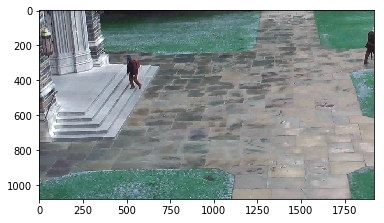

In [69]:
print(len(frames), frames_read)
plt.imshow(frames[0])

In [70]:
# save average for each camera
im_mean = np.mean(frames, axis=0).astype(np.uint8)
cv.imwrite(fp_out_cam_avg, im_mean)
fp_out_cam_avg = f'/data_store/datasets/people/duke_mtmc/processed/cam{cam}_average.png'

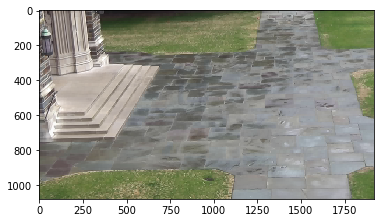

In [71]:
plt.imshow(cv.cvtColor(im_mean, cv.COLOR_BGR2RGB))

In [74]:
# create list of bboxes
dim = (1920, 1080)
bboxes = []
for d in tqdm(detections[str(cam)]):
  bboxes.append(BBox.from_xywh_dim(d['left'], d['top'], d['width'], d['height'], dim))

In [75]:
#size_draw = (1280, 720)
size_draw = (1920,1080)

In [76]:
# draw it
clr = (255,255,255)
im_draw = np.zeros([size_draw[1], size_draw[0], 3]).astype(np.uint8)
im_bg = im_draw.copy()
limit = 100000000
stroke_weight = 1
alpha = 0.05
cam = 5
fp_out_bboxes = f'/data_store/datasets/people/duke_mtmc/processed/duke_mtmc_bboxes_cam{cam}_alpha_{alpha}.png'
print(fp_out_bboxes)


/data_store/datasets/people/duke_mtmc/processed/duke_mtmc_bboxes_cam5_alpha_0.05.png


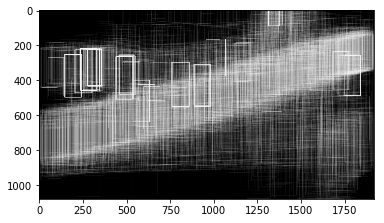

In [79]:
for i, bbox in enumerate(tqdm(bboxes)):
  if i % 60:
    continue
  bbox = bbox.to_dim(size_draw)
  pt1, pt2 = tuple(map(int, bbox.pt_tl)), tuple(map(int, bbox.pt_br))
  im_draw_next = im_bg.copy()
  cv.rectangle(im_draw_next, pt1, pt2, clr, stroke_weight, cv.LINE_AA)
  im_bg = cv.addWeighted(im_draw_next, alpha, im_bg, 1 - alpha, 0)
  if i > limit:
    break

cv.imwrite(fp_out_bboxes, im_bg)
plt.imshow(cv.cvtColor(im_bg, cv.COLOR_BGR2RGB))

In [45]:
# draw it
clr = (255, 255, 255)
size_orig = (5184, 3456)
scale = size_orig[0]/1920
size_draw = (int(size_orig[0]/scale), int(size_orig[1]/scale))
im_draw = np.zeros([size_draw[1], size_draw[0], 3]).astype(np.uint8)
im_bg = im_draw.copy()
limit = 2000000
stroke_weight = 1
alpha = 0.125

for i, roi in enumerate(tqdm(rois.items())):
  fname, bbox = roi  # expand
  bbox = bbox.to_dim(size_draw)
  pt1, pt2 = tuple(map(int, bbox.pt_tl)), tuple(map(int, bbox.pt_br))
  im_draw_next = im_bg.copy()
  cv.rectangle(im_draw_next, pt1, pt2, clr, stroke_weight, cv.LINE_AA)
  im_bg = cv.addWeighted(im_draw_next, alpha, im_bg, 1 - alpha, 0)
  if i > limit:
    break


plt.imshow(cv.cvtColor(im_bg, cv.COLOR_BGR2RGB))

NameError: name 'rois' is not defined

## Create Average Image

In [24]:
im_comp = np.empty_like(im_utils.resize(cv.imread(fp_im), width=1920) / 255)
for fp_im in tqdm(fp_ims[:100]):
  im = im_utils.resize(cv.imread(fp_im), width=1920) / 255
  im_comp += im

KeyboardInterrupt: 

In [25]:
im_mean = np.mean(ims, axis=0).astype(np.uint8)

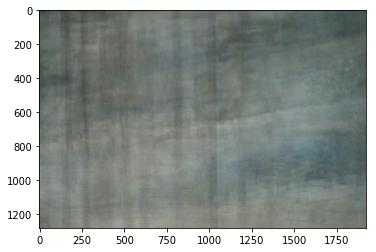

In [26]:
plt.imshow(im_mean)

In [19]:
a = np.array([.1, .2])
b = np.array([.1, .2])
c = a + b
print(c)


[0.2 0.4]


In [16]:
im = im.astype(np.)

array([[[0.16078431, 0.17254902, 0.1372549 ],
        [0.15686275, 0.16862745, 0.13333333],
        [0.15294118, 0.16470588, 0.12941176],
        ...,
        [0.49411765, 0.54509804, 0.5372549 ],
        [0.49411765, 0.54509804, 0.5372549 ],
        [0.49411765, 0.54509804, 0.5372549 ]],

       [[0.15294118, 0.16078431, 0.1372549 ],
        [0.14509804, 0.15294118, 0.12941176],
        [0.14509804, 0.15294118, 0.12941176],
        ...,
        [0.48627451, 0.5372549 , 0.52941176],
        [0.48627451, 0.5372549 , 0.52941176],
        [0.48627451, 0.5372549 , 0.52941176]],

       [[0.15294118, 0.16078431, 0.1372549 ],
        [0.14901961, 0.15686275, 0.13333333],
        [0.14509804, 0.15294118, 0.12941176],
        ...,
        [0.48235294, 0.53333333, 0.5254902 ],
        [0.49019608, 0.54509804, 0.5372549 ],
        [0.49803922, 0.55294118, 0.54509804]],

       ...,

       [[0.26666667, 0.29411765, 0.28235294],
        [0.27058824, 0.29803922, 0.28627451],
        [0.27058824, 0